In [1]:
import os

import matplotlib
import matplotlib.pyplot as plt

from jax.experimental.ode import build_odeint, odeint
import jax.numpy as np
from jax.random import PRNGKey
import numpy as onp

import numpyro
import numpyro.distributions as dist
# from numpyro.examples.datasets import LYNXHARE, load_dataset
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az

NUM_CHAINS = 1
numpyro.set_host_device_count(NUM_CHAINS)
numpyro.enable_x64()

# Data

In [2]:
import pandas as pd

ix = pd.IndexSlice

full = pd.read_csv('full.csv', index_col=['location', 'date', 'variable'], parse_dates=['date']).iloc[:, 0]
populations_country = pd.read_csv('populations_country.csv', index_col='location').iloc[:, 0]

country = 'France'
subset = full.loc[country]
deaths_subset = subset.loc[ix[:, 'total_deaths']]

pop_country = populations_country.loc[country]

ten_deaths_date = deaths_subset.gt(10).cumsum().loc[lambda s: s==1].index[0]
begin_date = ten_deaths_date - pd.Timedelta(30, unit='days')

total_deaths = deaths_subset.loc[begin_date:].values
# data = total_deaths / pop_country

times = deaths_subset.loc[begin_date:].index.map(onp.datetime64).to_numpy()

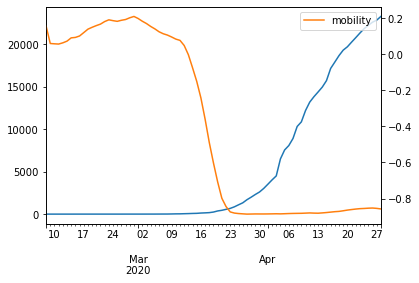

In [3]:
mobility = subset.loc[ix[:, 'transit']].rename('mobility')
mobility = mobility.reindex(deaths_subset.loc[begin_date:].index).fillna(mobility.iloc[-1]).rolling('7d').mean()

to_plot = pd.DataFrame({'deaths': total_deaths}, index=times).join(mobility)
to_plot['deaths'].plot(label='deaths')
to_plot['mobility'].plot(secondary_y=True)
plt.legend() ;

## France data
This data is rich, because we have the number of hospitalized and critical.

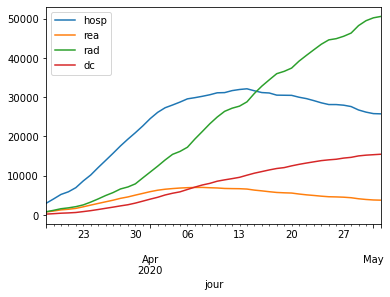

In [4]:
hosp = (pd.read_csv('donnees-hospitalieres-covid19-2020-05-02-19h00.csv', sep=';', parse_dates=['jour'])
        .loc[lambda f: f['sexe'] == 0]
        .groupby('jour')
        .sum()
        .drop('sexe', axis=1))

hosp_indexed = hosp.reindex(times).fillna(0)
hosp.plot() ;

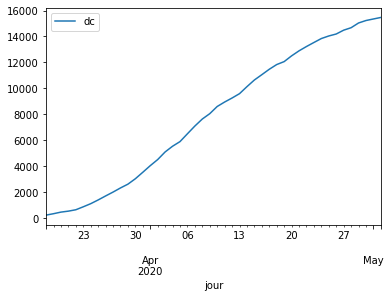

In [5]:
hosp.dc.plot()
plt.legend() ;

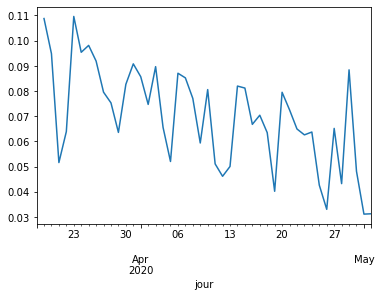

In [6]:
hosp.eval('dc.diff() / rea').plot() ;

# SEIR-HCD

https://www.kaggle.com/anjum48/seir-hcd-model

## Prior choice

We use France's Covid data, that includes the number of critical, deceased, hospitalized (and recovered).

## Implementation

In [9]:
mobility_data = np.asarray(mobility.to_numpy())

def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
    s = z[0]
    e = z[1]
    i = z[2]
    r = z[3]
    h = z[4]
    c = z[5]

    int_t = np.array([t]).astype(int)[0]
    rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]
    
    ds = - (rt / t_inf) * i * s
    de = (rt / t_inf) * i * s - (e / t_inc)
    di = e / t_inc - i / t_inf
    dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
    dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
    dc = c_a * h / t_hosp - c / t_crit
    dd = f_a * c / t_crit
    
    return np.stack([ds, de, di, dr, dh, dc, dd])

seirhcd_int = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)

In [10]:
def reparametrize_beta(mean, v):
#     v = numpyro.sample(f'sample_size_{i}', dist.Gamma(*reparametrize_gamma(10., 5)))
    return mean * v, (1 - mean) * v

def reparametrize_gamma(mean, std):
    var = std ** 2
    alpha = mean ** 2 / var
    beta = mean / var
    return alpha, beta

def model(N, y=None, compartments='d'):
    i_init = numpyro.sample('i_init', dist.Gamma(*reparametrize_gamma(100, 50.))) / pop_country
    z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
    ts = np.arange(float(N))
    
    kappa0 = numpyro.sample('kappa0', dist.TruncatedNormal(0, 0., 0.5))
    kappa1 = numpyro.sample('kappa1', dist.TruncatedNormal(0, 0, 0.5))
    r0 = numpyro.sample('r0', dist.TruncatedNormal(0, 3.28, kappa0))
    r1 = numpyro.sample('r1', dist.TruncatedNormal(0., 0.7, kappa1))
    
#     t_delta = numpyro.sample('t_delta', dist.Gamma(*reparametrize_gamma(3., 1.)))
#     t_delta = int(np.floor(t_delta))
    
    t_inc = numpyro.sample('t_inc', dist.Gamma(*reparametrize_gamma(5.6, .86)))
    t_inf = numpyro.sample('t_inf', dist.Gamma(*reparametrize_gamma(2.9, 1.)))
    t_hosp = numpyro.sample('t_hosp', dist.Gamma(*reparametrize_gamma(4., 1.)))
    t_crit = numpyro.sample('t_crit', dist.Gamma(*reparametrize_gamma(14., 1.)))
    
    sample_size = numpyro.sample('sample_size', dist.Exponential(1.0))
    m_a = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(0.8, sample_size)))
    c_a = numpyro.sample('c_a', dist.Beta(*reparametrize_beta(0.1, sample_size)))
    f_a = numpyro.sample('f_a', dist.Beta(*reparametrize_beta(0.35, sample_size)))
    
    params = (r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a)
    
    z = seirhcd_int(z_init, ts, *params)
    
    total_deaths = z[:, -1] * pop_country
    daily_deaths = np.hstack((np.array([0.]), np.diff(z[:, -1] * pop_country))) + 1
#     daily_critical = np.hstack((np.array([0]), np.diff(z[:, -2] * pop_country))) + 1
#     daily_hosp = np.hstack((np.array([0]), np.diff(z[:, -2] * pop_country))) + 1
    critical = z[:, -2] * pop_country + 1
    hosp = z[:, -3] * pop_country + 1
    psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
    
    if compartments == 'd':
        numpyro.sample('y', dist.GammaPoisson(psi, rate=psi / daily_deaths), obs=y)

    elif compartments == 'hcd':
        psi_h = numpyro.sample('psi_h', dist.TruncatedNormal(scale=5.))
        psi_c = numpyro.sample('psi_c', dist.TruncatedNormal(scale=5.))
        numpyro.sample('y', dist.GammaPoisson(
            np.stack([psi_h, 
                      psi_c, 
                      psi]),
            rate=np.array([psi_h / hosp, psi_c / critical, psi / daily_deaths]).T),
                       obs=y)

In [11]:
daily_deaths = np.hstack((np.array([0.]), np.diff(hosp_indexed['dc'].to_numpy())))

In [90]:
# # To use for regular (only deaths) data
# # use dense_mass for better mixing rate
# mcmc = MCMC(NUTS(model, dense_mass=True),
#             2000, 2000, num_chains=NUM_CHAINS,
#             progress_bar=True)
# mcmc.run(PRNGKey(0), N=daily_deaths.shape[0], y=daily_deaths + 1, compartments='d')
# mcmc.print_summary()

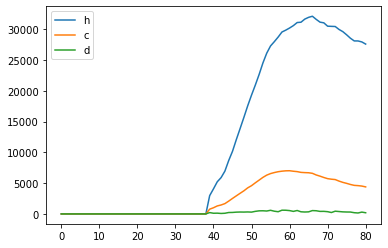

In [15]:
# daily_critical = np.hstack((np.array([0.]), np.diff(hosp_indexed['rea'].to_numpy()))) + 1
# daily_hosp = np.hstack((np.array([0.]), np.diff(hosp_indexed['hosp'].to_numpy()))) + 1

data = np.stack([hosp_indexed['hosp'].to_numpy(), hosp_indexed['rea'].to_numpy(), daily_deaths]).T + 1
data.shape

df = pd.DataFrame(data)
df.columns = 'h c d'.split()
df.plot()

In [29]:
# For HCD observations
# use dense_mass for better mixing rate
mcmc = MCMC(NUTS(model, dense_mass=True),
            1000, 1000, num_chains=NUM_CHAINS,
            progress_bar=True)
mcmc.run(PRNGKey(0), N=data.shape[0], y=data, compartments='hcd')
mcmc.print_summary()

sample: 100%|██████████| 800/800 [10:29<00:00,  1.27it/s, 1023 steps of size 2.56e-04. acc. prob=0.93] 



                   mean       std    median      5.0%     95.0%     n_eff     r_hat
          c_a      0.13      0.03      0.12      0.09      0.17      3.63      1.68
          f_a      1.00      0.00      1.00      1.00      1.00      5.89      1.00
       i_init      0.06      0.03      0.05      0.01      0.11     16.70      1.02
       kappa0      1.06      0.16      1.05      0.84      1.29      3.09      2.26
       kappa1      0.02      0.01      0.02      0.01      0.03      7.62      1.06
          m_a      1.00      0.00      1.00      0.99      1.00      5.87      1.46
          psi      1.91      0.21      1.91      1.62      2.21      4.39      1.34
        psi_c      1.65      0.15      1.68      1.42      1.90      5.99      1.35
        psi_h      0.52      0.02      0.52      0.49      0.56      4.91      1.45
           r0      5.67      0.41      5.65      5.05      6.36      5.91      1.53
           r1      0.70      0.02      0.70      0.66      0.73     44.36  

In [89]:
def plot_compartment_results(mu, pi, y_true, times):
    plt.plot(times, y_true, "bx", label="true")
    plt.plot(times, mu, "b--", label="pred")
    plt.fill_between(times, pi[0, :], pi[1, :], color="b", alpha=0.3)
    plt.legend()
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.title('Daily deaths')

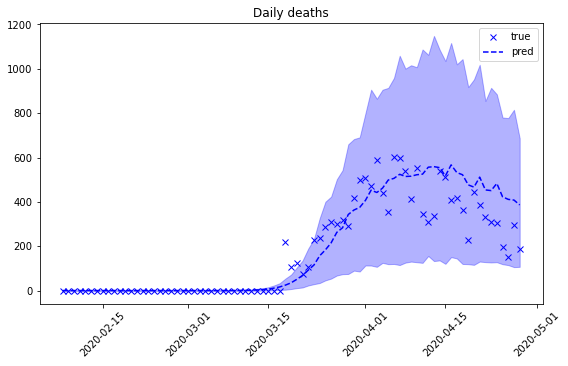

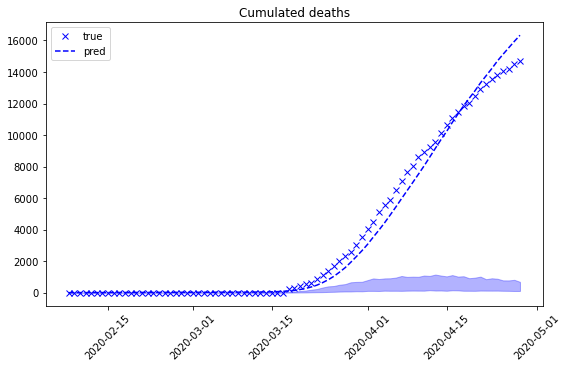

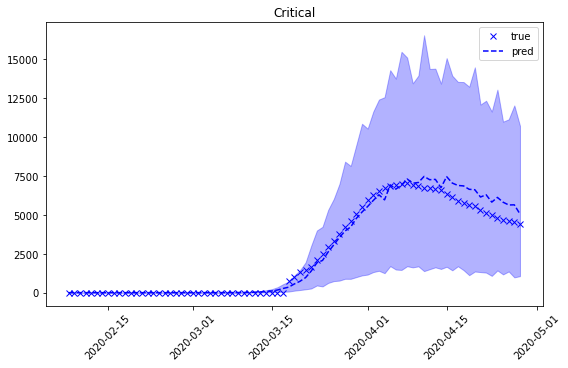

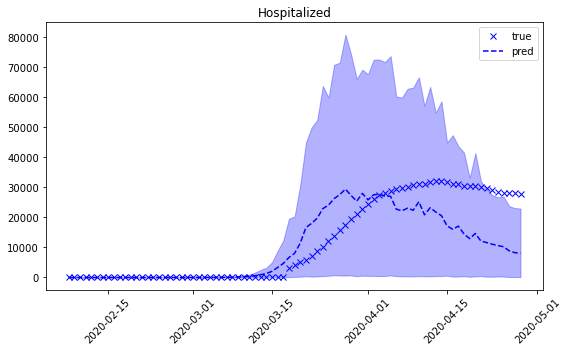

In [31]:
# # Control for HCD params
def plot_hcd_results(mu, pi, data, daily_deaths, times):
    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -1], pi[:, :, -1], daily_deaths, times)
    plt.title('Daily deaths')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(np.cumsum(mu[:, -1]), pi[:, :, -1], np.cumsum(daily_deaths), times)
    plt.title('Cumulated deaths')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -2], pi[:, :, -2], data[:, -2], times)
    plt.title('Critical')

    fig, ax = plt.subplots(figsize=(8, 5))
    plot_compartment_results(mu[:, -3], pi[:, :, -3], data[:, -3], times)
    plt.title('Hospitalized')

    
y_pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0], compartments='hcd')['y']
pop_pred = y_pred
mu = np.mean(pop_pred, 0)
pi = np.percentile(pop_pred.astype(float), (10., 90.), 0)

plot_hcd_results(mu, pi, data, daily_deaths, times)
plt.tight_layout()

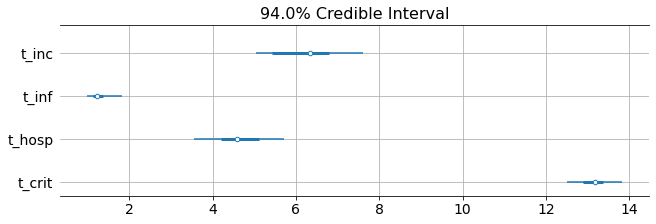

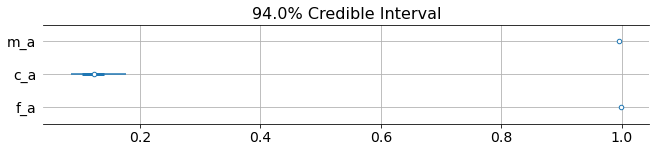

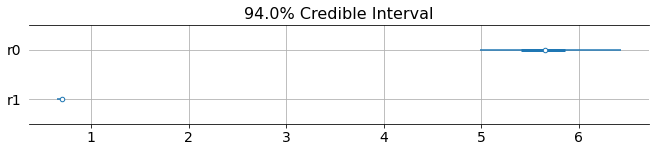

In [32]:
inference_data = az.from_numpyro(mcmc)

az.plot_forest(inference_data, var_names=['t_inc', 't_inf', 't_hosp', 't_crit'], kind='forestplot', ridgeplot_overlap=3, combined=True, figsize=(9, 3))
plt.grid()
az.plot_forest(inference_data, var_names=['m_a', 'c_a', 'f_a'], figsize=(9, 2))
plt.grid()
az.plot_forest(inference_data, var_names=['r0', 'r1'], figsize=(9, 2))
plt.grid()
# az.plot_forest(inference_data, var_names=['t_lim'], figsize=(9, 1))

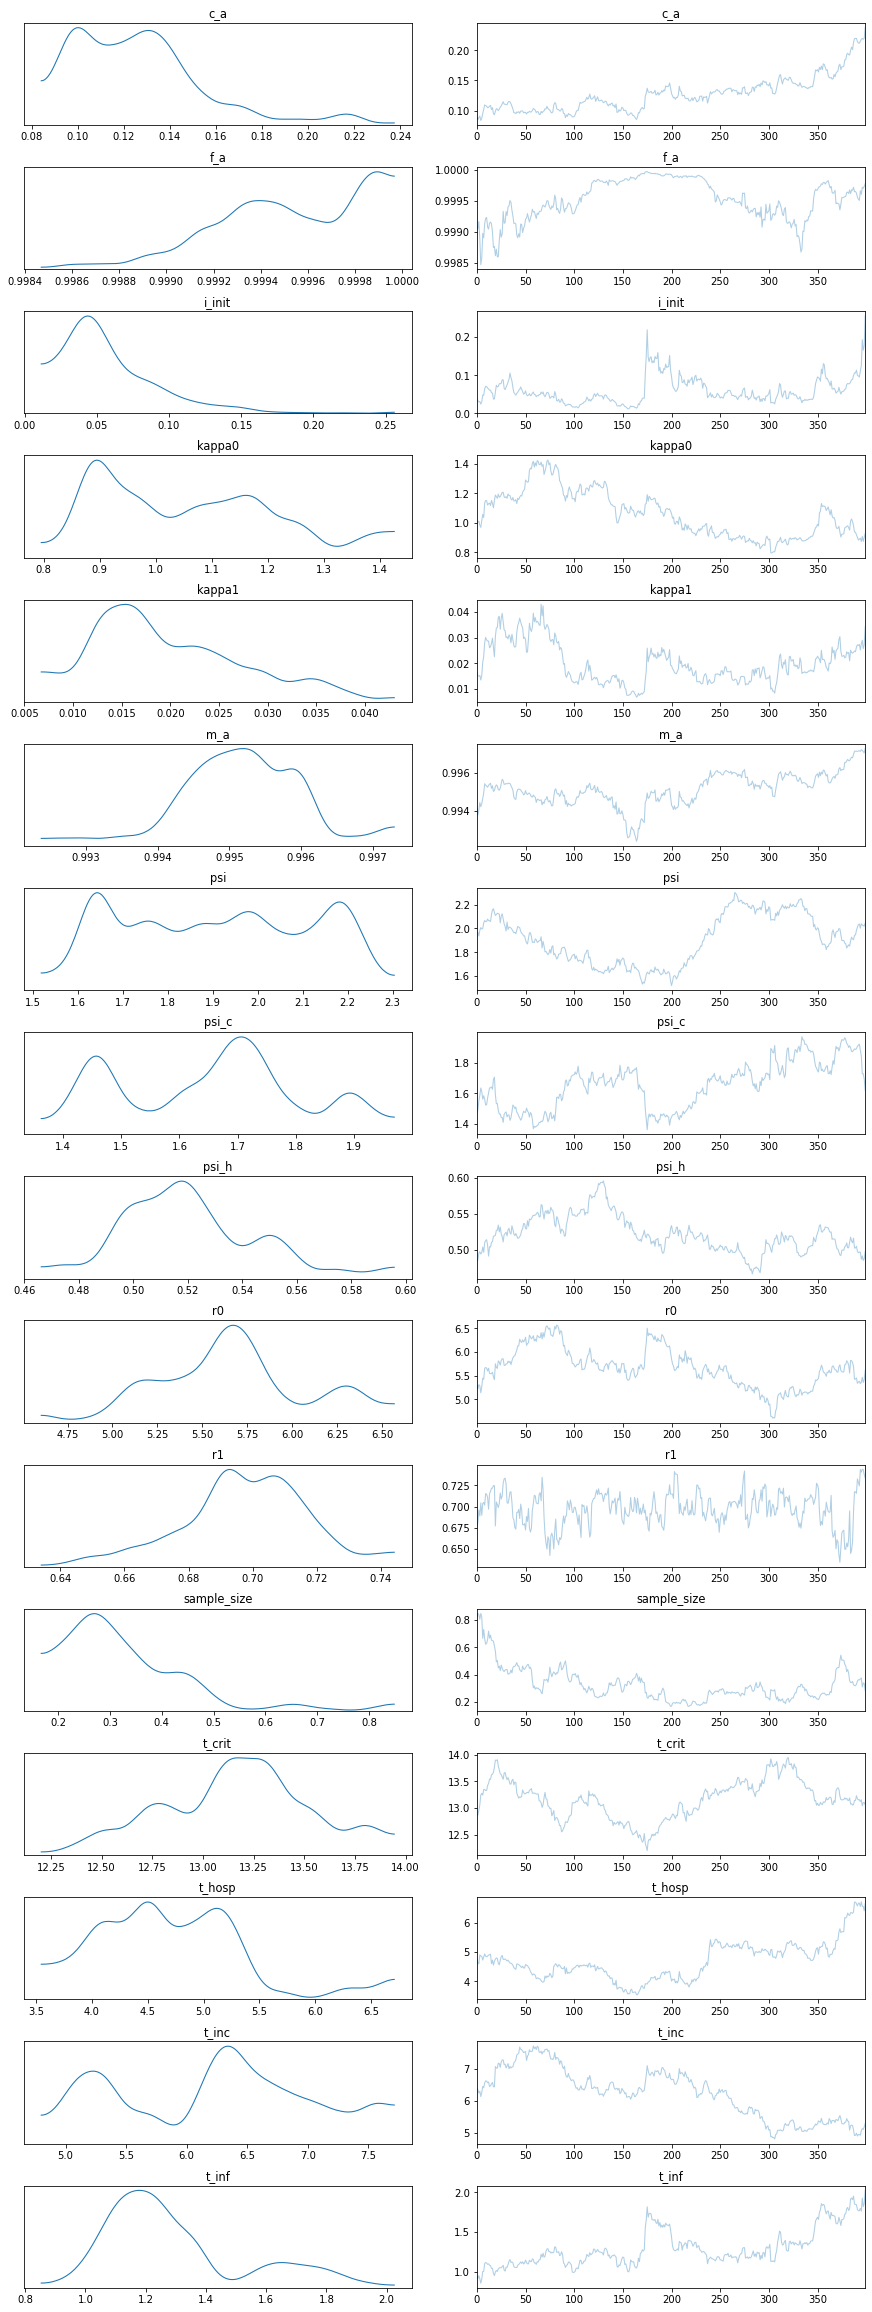

In [33]:
az.plot_trace(inference_data) ;

## Running the compartment model

In [34]:
samples = mcmc.get_samples()
# pred = Predictive(model, mcmc.get_samples())(PRNGKey(2), data.shape[0])

In [75]:
def run_sim_samples(mobility_data, samples):
    def dz_dt(z, t, r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a):
        s = z[0]
        e = z[1]
        i = z[2]
        r = z[3]
        h = z[4]
        c = z[5]

        int_t = np.array([t]).astype(int)[0]
        rt = r0 * (1 + mobility_data[int_t]) - r1 * mobility_data[int_t]

        ds = - (rt / t_inf) * i * s
        de = (rt / t_inf) * i * s - (e / t_inc)
        di = e / t_inc - i / t_inf
        dr = m_a * i / t_inf + (1 - c_a) * (h / t_hosp)
        dh = (1 - m_a) * (i / t_inf) + (1 - f_a) * c / t_crit - h / t_hosp
        dc = c_a * h / t_hosp - c / t_crit
        dd = f_a * c / t_crit

        return np.stack([ds, de, di, dr, dh, dc, dd])


    ts = np.arange(float(data.shape[0]))
    seirhcd_int_2 = build_odeint(dz_dt, rtol=1e-5, atol=1e-9, mxstep=500)
    res = []
    for i in range(samples['c_a'].shape[0]):
        post_params = dict()
        for param in 'r0, r1, t_inc, t_inf, t_hosp, t_crit, m_a, c_a, f_a'.split(', '):
            post_params[param] = samples[param][i]
    #         post_params[param] = inference_data.posterior[param].values[0, -1]

        i_init = samples['i_init'][i]
        i_init /= pop_country
        z_init = np.array([1. - i_init, 0., i_init, 0., 0., 0., 0.])
        args = post_params.values()

        sim_res = seirhcd_int_2(z_init, ts, *args)
        res.append(sim_res)

    res = np.stack(res)
    return res

In [76]:
def plot_compartment(pred_data, true_data):
    pi = np.percentile(pred_data, (10., 90.), 0)
    
    plt.plot(times, np.mean(pred_data, axis=0) * pop_country, label='pred')
    plt.plot(times, true_data, label='true')
    plt.fill_between(times, pi[0, :] * pop_country, pi[1, :] * pop_country, interpolate=True, alpha=0.3)
    plt.legend()

In [93]:
def plot_hcd(res, hosp_indexed):

    plt.subplots()
    plot_compartment(res[:, :, -3], hosp_indexed['hosp'].to_numpy())
    plt.title('hospitalized')

    plt.subplots()
    plot_compartment(res[:, :, -2], hosp_indexed['rea'].to_numpy())
    plt.title('critical')

    
    plt.subplots()
    plot_compartment(res[:, :, -1], hosp_indexed['dc'].to_numpy())
    plt.title('deaths')
    
def plot_seir(res):
    plt.subplots()
    plot_compartment(res[:, :, 0], np.zeros(res.shape[1]))
    plt.title('susceptible')

    plt.subplots()
    plot_compartment(res[:, :, 1], np.zeros(res.shape[1]))
    plt.title('exposed')

    plt.subplots()
    plot_compartment(res[:, :, 2], np.zeros(res.shape[1]))
    plt.title('infected')
    
    plt.subplots()
    plot_compartment(res[:, :, 3], np.zeros(res.shape[1]))
    plt.title('recovered')


In [81]:
mobility_data = np.asarray(mobility.to_numpy())
res = run_sim_samples(mobility_data, samples)

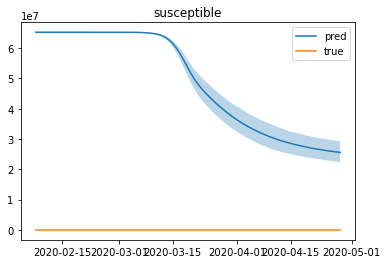

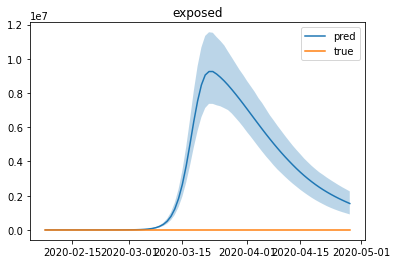

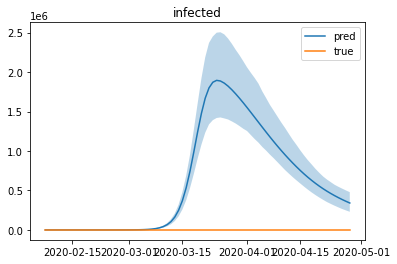

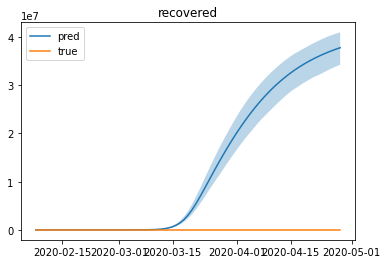

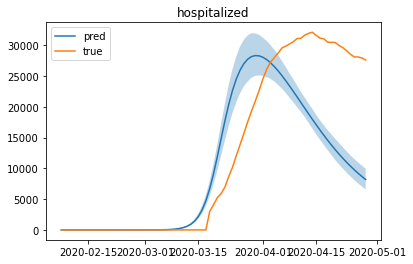

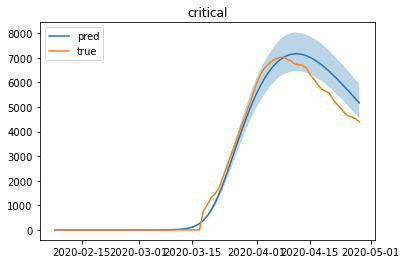

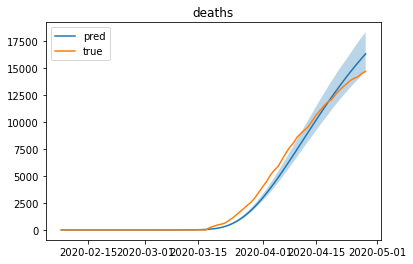

In [94]:
plot_seir(res)
plot_hcd(res, hosp_indexed)

In [82]:
mobility_fake = np.zeros(mobility_data.shape[0])
res_fake = run_sim_samples(mobility_fake, samples)

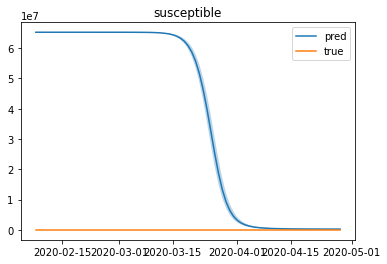

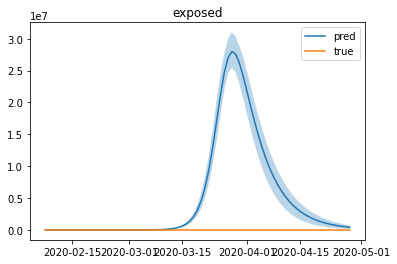

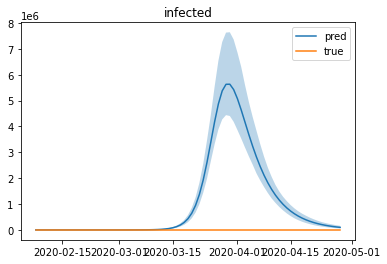

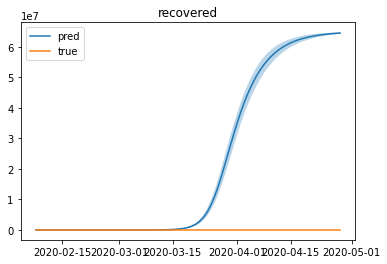

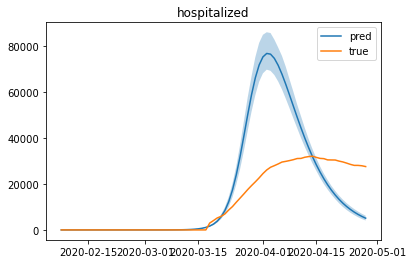

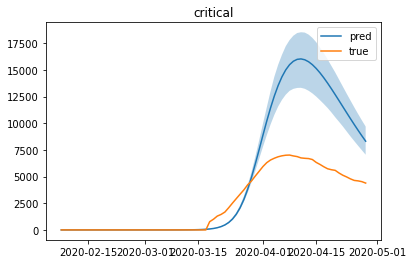

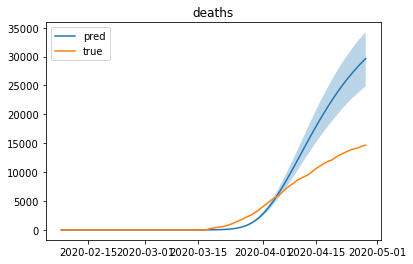

In [95]:
plot_seir(res_fake)
plot_hcd(res_fake, hosp_indexed)

## When res only contains one series per compartment

In [88]:
# df_res = pd.DataFrame(res) * pop_country
# df_res.columns = 's e i r h c d'.split()

# fig, ax = plt.subplots()
# df_res = df_res.eval('total_cases = i + r + h + c + d').set_index(times)
# df_res['d'].plot(figsize=(8, 5), ax=ax)
# total_deaths_indexed = pd.DataFrame({'true': total_deaths}).set_index(times)
# total_deaths_indexed.plot(ax=ax)
# plt.legend() ;

# fig, ax = plt.subplots()
# df_res['total_cases'].plot()
# subset.loc[ix[:, 'total_cases']].plot(ax=ax, secondary_y=True)

# Misc

In [ ]:
# checking some distributions
daily_deaths = np.array([0, 0, 1, 2, 3, 5]) + 1

for i in range(100):
    with numpyro.handlers.seed(rng_seed=i):
        psi = numpyro.sample('psi', dist.TruncatedNormal(scale=5.))
#         print(f'{psi=}')
        gp_sample = numpyro.sample('y', dist.GammaPoisson(psi * daily_deaths, rate=psi))
#         print(gp_sample)
        beta_sample = numpyro.sample('m_a', dist.Beta(*reparametrize_beta(0.8, numpyro.sample('sample_size', dist.Exponential(1.0)))))
#         print(beta_sample)